In [1]:
import sys
sys.path.append('..')

In [114]:
from datetime import datetime
from pathlib import Path
from itertools import product, combinations
from operator import itemgetter

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from cashback_calculator.db import Card, N_MCCS, ALL_MCCS, MCC2ID, ID2MCC, \
    MCC_CATEGORIES, CARD_IDS
from cashback_calculator.two_card_strategy_optimisation import optimize_cashback, \
    optimize_cashback_for_cards

from myutils.json import save_json, load_json

%config InlineBackend.figure_formats = ['svg']
plt.rcParams['figure.facecolor'] = 'white'
plt.style.use('seaborn-deep')

In [3]:
rcparams = {
    'text.usetex' : True,
    'font.family': [
        'serif'
    ],
    'font.serif': [
        'Computer Modern Roman',
        'Times',
        'Palatino',
        'New Century Schoolbook',
        'Bookman',
    ],
}

plt.rcParams.update(rcparams)

In [4]:
dblue = '#27488b'
lblue = '#6d92de'
dred = '#d91f43'

In [5]:
money_movement = pd.read_csv('../data/money_movement.csv', dtype={'mcc': str}, parse_dates=['date'])

date_mask = (money_movement['date'] >= datetime(year=2019, month=12, day=1))\
    & (money_movement['date'] < datetime(year=2020, month=12, day=1))

money_movement = money_movement[date_mask].reset_index(drop=True)

money_movement['month'] = money_movement['date'].apply(lambda x: x.replace(day=1))

money_movement.head(2)

,date,income,expense,mcc,is_cashback,month
0,2019-12-01,0.0,288.0,5814,False,2019-12-01
1,2019-12-01,0.0,200.0,5411,False,2019-12-01


## Testing workability

In [6]:
month = money_movement['month'].unique()[-1]
month

numpy.datetime64('2020-11-01T00:00:00.000000000')

In [7]:
spendings = money_movement.loc[money_movement['month'] == month].groupby('mcc')['expense'].sum()
vector = spendings.reindex(ALL_MCCS).fillna(0).values * 1.5

vector.shape, vector.sum()

((572,), 90683.78999999998)

In [55]:
cards = [Card(card_id) for card_id in CARD_IDS]

len(cards)

14

In [9]:
c1 = cards[5]
c2 = cards[9]

c1, c2

(Card(card_id='bspb_visa-cashback', bank_id='bspb'),
 Card(card_id='bspb_travel', bank_id='bspb'))

In [10]:
c1.benchmarks, c2.benchmarks

(array([ 0., inf]), array([ 0., inf]))

In [11]:
result = optimize_cashback(vector, cards, progress_bar=True)

  0%|          | 0/91 [00:00<?, ?it/s]

In [12]:
result[0][-1]

3357.6078000447224

## Testing time complexity

In [13]:
runtime = load_json('../data/tests/speed_test_results.json')

runtime = pd.DataFrame(runtime, columns=['n', 't'])

runtime.head(2)

,n,t
0,2.0,0.000172
1,2.0,0.003991


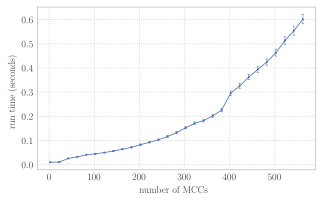

In [123]:
plt.figure(figsize=(5, 3))

sns.lineplot(data=runtime, x='n', y='t', lw=0.8, color='C0',
             marker='.', markersize=4, markeredgewidth=0,
             zorder=5,
             err_style='bars', err_kws={'linewidth': 0.5, 'ecolor': 'C0', 'capsize': 1.2, 'capthick': 0.5})

plt.grid(ls='dotted')
plt.xlabel('number of MCCs')
plt.ylabel('run time (seconds)')

plt.savefig('../data/figures/runtime.eps', bbox_inches='tight')

## Testing vs. brute force

In [32]:
mcc_categories = {
    category: mccs[:1]
    for category, mccs in MCC_CATEGORIES.items()
}

mcc2category = {
    mcc: category
    for category, mccs in mcc_categories.items()
    for mcc in mccs
}

mcc2category

{'5811': 'restaurants',
 '5814': 'fastfood',
 '5541': 'fuel',
 '4121': 'taxi',
 '5411': 'groceries',
 '5912': 'pharmacies',
 '7832': 'cinema',
 '3000': 'airlines',
 '1711': 'other'}

In [33]:
def get_vector(amount_spent_by_category) -> np.ndarray:
    vector = np.zeros(N_MCCS)
    
    for key, value in amount_spent_by_category.items():
        if value > 0:
            value -= 0.01
            mccs = mcc_categories[key]
            n_mccs = len(mccs)
            mask = list(map(MCC2ID.get, mccs))
            vector[mask] = value / n_mccs
            
    return vector

In [34]:
category_values = [
    ('restaurants', 15000, 3000),
    ('fastfood', 5000, 1000),
    ('fuel', 1500, 500),
    ('taxi', 2500, 500),
    ('groceries', 1800, 2000),
    ('pharmacies', 2000, 1000),
    ('cinema', 3500, 1000),
    ('airlines', 10000, 4000),
    ('other', 20000, 1500)
]

In [35]:
def get_random_spendings_vector(n_values: int = 6) -> np.ndarray:
    inds = np.random.choice(np.arange(len(category_values)), size=n_values, replace=False)
    amount_spent_by_category = {}
    
    for i in inds:
        name, mu, sigma = category_values[i]
        amount = np.random.normal(mu, sigma)
        amount_spent_by_category[name] = amount
        
    vector = get_vector(amount_spent_by_category)
    vector[vector < 0] = 0
    
    return vector * 2

In [52]:
vector = get_random_spendings_vector(6)

vector.sum()

61477.54508162126

In [53]:
def maximize_profit_brute_force(
        spendings_vector: np.ndarray,
        c1: Card,
        c2: Card,
        grid_size: int = 3,
        progress_bar: bool = False,
) -> float:
    nonzero_ids = np.where(spendings_vector > 0)[0]
    
    grid = list(product(np.linspace(0, 1, grid_size), repeat=len(nonzero_ids)))
    results = []
    
    for values in tqdm(grid, disable=not progress_bar):
        x = np.zeros(spendings_vector.size)
        x[nonzero_ids] = np.array(list(values))
        
        profit = c1.calculate_profit(spendings_vector * x) + c2.calculate_profit(spendings_vector * (1 - x))
        results.append((x, profit))
            
    x, profit = max(results, key=itemgetter(1))
    
    return x, profit

In [81]:
results = []

fo../data/n trange(5):
    vector = get_random_spendings_vector(6)
    
    for j, (c1, c2) in enumerate(combinations(cards, 2)):
        _, _, _, profit_opt = optimize_cashback_for_cards(vector, c1, c2)
        _, profit_brute_force = maximize_profit_brute_force(vector, c1, c2, grid_size=4)
    
        if j % 50 == 0:
            err = np.mean([r[2] - r[3] for r in results[-50:]])
            print(err)
    
        results.append((c1, c2, profit_opt, profit_brute_force))
        
results = pd.DataFrame(results, columns=['c1', 'c2', 'opt', 'bf'])

results['diff'] = (results['opt'] - results['bf']) / results['opt']
results = results.sort_values(by='diff', ascending=False)

results.head(2)

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/yuralytkin/Development/.globalvenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yuralytkin/Development/.globalvenv/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
-3.493095896374143e-05
-3.4311782633267286e-05
0.14857744780238136
4.166798031981989
-6.374987151502865e-08
0.5678572451733317
0.5678572441981714
-9.061602440851857e-07
-2.2613717646891017e-06
-2.944575172136865e-07
3.4803832477336983e-06
-4.1341149881191083e-08
0.05512601688153609
0.05512601950620137
-1.786849566087767e-06
-2.9255241997816483e-06
-3.215251354049542e-09
-2.565795739428722e-07
-2.0358447727630845e-08


/Users/yuralytkin/Development/work/itmo/cashback-calculator/notebooks/../cashback_calculator/two_card_strategy_optimisation.py:74: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  result = linprog(
/Users/yuralytkin/Development/work/itmo/cashback-calculator/notebooks/../cashback_calculator/two_card_strategy_optimisation.py:74: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  result = linprog(
/Users/yuralytkin/Development/.globalvenv/lib/python3.8/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.13146e-26): result may not be accurate.
  return sp.linalg.solve(M, r, s

0.027757752430056827
0.0277577366586911
-1.652149421715876e-07
-1.776813633114216e-07
0.016948542667873313
-3.4418706036376533e-07
-1.8099808585247957e-08
0.38608469329849415
0.38608469781659094
-5.2145105655654335e-08
0.4256323037003085
0.013181665923974606
-1.1000792028426077e-07
-4.8479466840944954e-08
-9.93303274299251e-08


,c1,c2,opt,bf,diff
20,"Card(card_id='tinkoff_drive', bank_id='tinkoff')","Card(card_id='bspb_travel', bank_id='bspb')",1860.284602,1860.28495,-1.871814e-07
13,"Card(card_id='tinkoff_drive', bank_id='tinkoff')","Card(card_id='raiffeisen_cashback', bank_id='r...",1860.284602,1860.28495,-1.871814e-07


In [104]:
results.to_csv('../data/tests/vs_brute_force.csv', index=False)

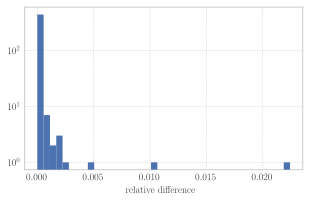

In [124]:
plt.figure(figsize=(5, 3))

hist = plt.hist(results['diff'], bins=40, zorder=5)

plt.grid(ls='dotted')
plt.xlabel('relative difference')
plt.yscale('log')

plt.savefig('../data/figures/vs_brute_force.eps', transparent=True, bbox_inches='tight')

## Results on real data

<AxesSubplot:xlabel='month'>

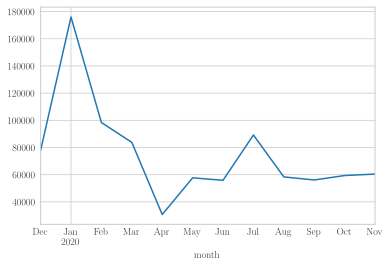

In [22]:
monthly_spendings = money_movement.groupby('month')['expense'].sum()

monthly_spendings.plot()

<AxesSubplot:xlabel='month'>

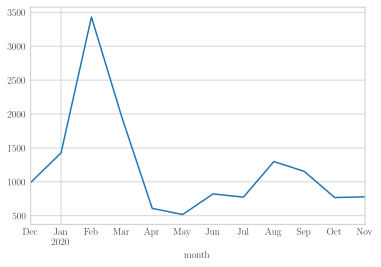

In [23]:
monthly_cashback = money_movement[money_movement['is_cashback']].groupby('month')['income'].sum()

monthly_cashback.plot()

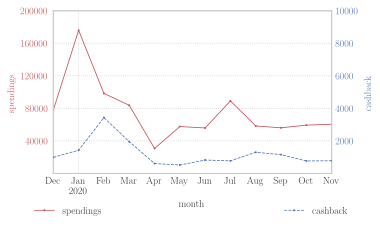

In [125]:
plt.figure(figsize=(5, 3))

ax1 = plt.gca()

monthly_spendings.plot(ax=ax1, lw=0.8, zorder=5,
                       marker='.', markersize=2, color='C2',
                       label='spendings')

# ax1.plot(monthly_spendings, lw=0.8, zorder=5,
#          marker='.', markersize=2, color='C2', label='spendings')

ax1.set_xlabel('month')
ax1.set_ylabel('spendings', color='C2')
# ax1.tick_params(axis='x', rotation=10)
ax1.tick_params(axis='y', labelcolor='C2')
ax1.grid(ls='dotted')
ax1.legend(loc='upper left', bbox_to_anchor=(-0.1, -0.15))

yticks = np.arange(0, 240000, 40000)
ax1.set_yticks(yticks[1:])
ax1.set_yticklabels(yticks[1:])
ax1.set_ylim(yticks[0], yticks[-1])

ax2 = ax1.twinx()

monthly_cashback.plot(ax=ax2, lw=0.8, zorder=5,
                      marker='.', markersize=2, color='C0',
                      ls='dashed', label='cashback')

# ax2.plot(monthly_cashback_filled, lw=0.8, zorder=5,
#          marker='.', markersize=2, color='C0', ls='dashed', label='cashback')

yticks = yticks // 20
ax2.set_yticks(yticks[1:])
ax2.set_yticklabels(yticks[1:])
ax2.set_ylim(yticks[0], yticks[-1])

ax2.set_ylabel('cashback', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')
ax2.legend(loc='upper right', bbox_to_anchor=(1.1, -0.15))
ax2.grid(False)

plt.savefig('../data/figures/real_spendings_vs_cashback.eps', bbox_inches='tight')

In [47]:
all_mccs = money_movement.loc[money_movement['mcc'].notna(), 'mcc'].unique().tolist()

cards = [Card(card_id, all_mccs) for card_id in CARD_IDS]

len(cards)

14

In [48]:
profit = []

for month in tqdm(money_movement['month'].unique()):
    vector = money_movement[money_movement['month'] == month].groupby('mcc')['expense'].sum()
    vector = vector.reindex(all_mccs).fillna(0).values
    
    for c in cards:
        p = c.calculate_profit(vector)
        profit.append((c.card_name, 'None', month, p))

    for c1, c2 in combinations(cards, 2):
        _, _, _, p = optimize_cashback_for_cards(vector, c1, c2)
        profit.append((c1.card_name, c2.card_name, month, p))

profit = pd.DataFrame(profit, columns=['c1', 'c2', 'month', 'profit'])

profit.head(2)

  0%|          | 0/12 [00:00<?, ?it/s]

,c1,c2,month,profit
0,Tinkoff Black,None,2019-12-01,706.3379
1,Tinkoff Drive,None,2019-12-01,706.3379


In [49]:
total_profit = profit.groupby(['c1', 'c2'])['profit'].sum().sort_values(ascending=False).reset_index()

total_profit.head()

,c1,c2,profit
0,Bank SPb Cashback,Bank SPb MC World,30592.674260
1,Bank SPb Cashback,Alfabank Alfacard,29815.003309
2,Bank SPb Cashback,Bank SPb Travel,29034.761870
3,Raiffeisen Cashback Card,Bank SPb Cashback,28818.906260
4,Bank SPb Cashback,Sberbank Large Bonuses Card,27385.294334


In [29]:
total_profit[total_profit['c2'] == 'None'].head()

,c1,c2,profit
10,Bank SPb Cashback,None,25586.14210
36,Bank SPb MC World,None,17312.10650
41,Sberbank Large Bonuses Card,None,17250.18645
50,Bank SPb EKP,None,16310.22210
66,Alfabank Alfacard,None,14000.44470


In [30]:
ids = [1, 3, 10, 41]

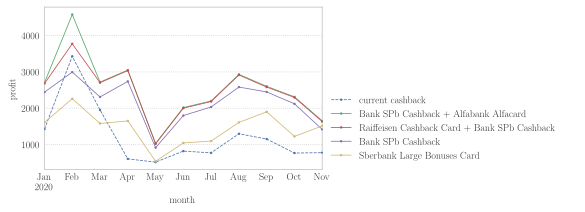

In [126]:
plt.figure(figsize=(5, 3))

monthly_cashback.iloc[1:]\
    .plot(label='current cashback', lw=0.8,
          ls='dashed', marker='.', markersize=3,
          zorder=5, color='C0')

# plt.plot(monthly_cashback_filled, label='Current cashback',
#          lw=0.8, ls='dashed', marker='.', markersize=3, zorder=5, color='C0')

for j, i in enumerate(ids, start=1):
    row = total_profit.loc[i]
    
    c1 = row['c1']
    c2 = row['c2']
    
    cards_profit = profit[(profit['c1'] == c1) & (profit['c2'] == c2)]
    
    label = c1
    
    if c2 != 'None':
        label += ' + ' + c2
    
    color = f'C{j}'
    
    cards_profit.set_index('month')['profit'].shift().iloc[1:]\
        .plot(label=label, lw=0.8,marker='.', markersize=3, zorder=5, color=color)
    
#     plt.plot(cards_profit['month'], cards_profit['profit'], label=label,
#              lw=0.8, marker='.', markersize=3, zorder=5, color=color)
    
plt.legend(loc='lower left', bbox_to_anchor=(1, 0), prop={'size': 10})
# plt.xticks(rotation=10)
plt.grid(ls='dotted')
plt.xlabel('month')
plt.ylabel('profit')

plt.savefig('../data/figures/monthly_cashback.eps', bbox_inches='tight')